In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"

import sys
# sys.path = ['/home/jxm3/research/retrieval/inversion'] + sys.path
sys.path = [
    p for p in sys.path
    if p not in ['/home/jxm3/research/prompting/imodelsX', '/home/jxm3/research/prompting/tree-prompt']
]
sys.path.append('/home/jxm3/research/retrieval/inversion')

## debugging

we trained our first self-correcting model that's decoder-based. generation from it doesn't seem to be working properly, so going to debug in this notebook.

In [3]:
# model info:
#    https://wandb.ai/jack-morris/emb-correct-1/runs/e9430bc73cfd6fb433eb0e5401d4a7ff
#             path: saves/47d9c149a8e827d0609abbeefdfd89ac

import analyze_utils

checkpoint_folder = '/home/jxm3/research/retrieval/inversion/saves/47d9c149a8e827d0609abbeefdfd89ac'
trainer = analyze_utils.load_trainer(checkpoint_folder)

Loading trainer for analysis – setting --do_eval=1
loading alias dpr_nq__msl32_beta from /home/jxm3/research/retrieval/inversion/saves/db66b9c01b644541fedbdcc59c53a285/ebb31d91810c4b62d2b55b5382e8c7ea...
Set train_args.dataloader_num_workers = 4


/home/jxm3/.conda/envs/torch/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/jxm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jxm3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jxm3/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


================ Begin trainer sanity check ================
	Input to encode -> Twas brillig, and the slithy toves, Did gyre and gimble in the wabe, All mimsy were the borogoves, And the mome raths outgrabe.
	Decoded output -> Was slurred the togy, Was gilber and brittle, Did twave sliths
================ End trainer sanity check ================
Froze 342572160 params from model type <class 'models.inversion.InversionModel'>


[nltk_data] Downloading package wordnet to /home/jxm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jxm3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jxm3/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


================ Begin trainer sanity check ================
	Input to encode -> Twas brillig, and the slithy toves, Did gyre and gimble in the wabe, All mimsy were the borogoves, And the mome raths outgrabe.
	Decoded output -> Was tibe and willig, Did tore the slithy gyres, Did the brittle 
================ End trainer sanity check ================


In [10]:
trainer.inversion_trainer.model.use_frozen_embeddings_as_input = True
trainer.gen_kwargs = {
    "early_stopping": False,
    "num_beams": 1,
    "do_sample": False,
    "no_repeat_ngram_size": 0,
}
trainer.num_gen_recursive_steps = 1
for eval_dataset_name, eval_dataset in trainer.eval_dataset.items():
    metrics = trainer.evaluate(
        eval_dataset=eval_dataset,
        metric_key_prefix=f"eval_{eval_dataset_name}",
    )
    print(metrics)

[pred] Union at Newtri after talks with N S Turner, current fears are expressed when Union representatives at the meeting are disappointed, like pensions, workers disgru
[true] Fears for T N pension after talks Unions representing workers at Turner Newall say they are 'disappointed' after talks with stri



[pred] of the Human Space Race: FRONT GOES TOS – Second Man Starts a Private Space Launch Team Official Website: Todate
[true] The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORON



[pred] AP Research and Development Company wins a grant to study peptides - AP (company) - founded by students at University of
[true] Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of
setting preds_emb
{'eval_ag_news_loss': 2.07120943069458, 'eval_ag_news_token_set_precision': 0.5809505561595186, 'eval_ag_news_token_set_recall': 0.6001999148398365, 'eval_ag_news_token_set_f1': 0.5891242

[pred] we study phase behavior between a liquid crystal with a strong nematic pattern anchored in a binging crystal between the substrate and surrounding
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scale relations of observed uniform clusterings requires measuring large X observable samples. We sample the galaxy's x axi
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] demonstrating how to control a link type optical quantum correlation in degenerate spatial parametric modes of a multimode modulator, i
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb
{'eval_arxiv_loss': 1.7339985370635986, 'eval_arxiv_token_set_precision': 0.70533657366174

[pred] a former Sodje Trader denied the fraud charges against the Reading Sports Foundation, the National Fund for the Defence of Nigeria, for allegedly raising
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire after suffering an injury on the batting surface on 6 June for 62 in the County Championship. Somerset then hurt Middles
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in his first June edition in the magazine. While seated, the s
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
{'eval_xsum_doc_loss': 1.12234866619

[pred] Former Premier League footballer Sam Sodje has appeared before court, joined by three brothers and three brothers accused of fraud for their National Charity Farm charity.
[true] Former Premier League footballer Sam Sodje has appeared in court alongside three brothers accused of charity fraud.



[pred] Middlesex batsman Adam Voges will be out until December after torn calf muscle in his first-class leg in August.
[true] Middlesex batsman Adam Voges will be out until August after suffering a torn calf muscle in his right leg.



[pred] The Duchess of Cambridge will feature on the cover of British Vogue's cover to mark the magazine's centenary in the magazine.
[true] The Duchess of Cambridge will feature on the cover of British Vogue to mark the magazine's centenary.
setting preds_emb
{'eval_xsum_summ_loss': 1.2609869241714478, 'eval_xsum_summ_token_set_precision': 0.7845961496564842, 'eval_xsum_summ_token_set_recall': 0.7251062632396557, 'eval_xsum_summ_token_set_f1': 0.75008350

[pred] pope kilol ii. christian of Michail, also known as Khalil ab
[true] pope michael iii of alexandria -lrb- also known as khail i



[pred] hui jun hun is a male former professional table tennis player from China. He is a former men's tennis player. 
[true] hui jun is a male former table tennis player from china.



[pred] oztürk rb rb - born 30 November 1977 (Turk) is a lakh-
[true] okan ztürk -lrb- born 30 november 1977 -rrb- is a tur
setting preds_emb
{'eval_wikibio_loss': 2.2393977642059326, 'eval_wikibio_token_set_precision': 0.6312108164387288, 'eval_wikibio_token_set_recall': 0.6367846484693094, 'eval_wikibio_token_set_f1': 0.6313904667400375, 'eval_wikibio_bleu_score': 8.066843706711486, 'eval_wikibio_meteor_score': 0.397198126557718, 'eval_wikibio_rouge_score': 0.49090856778366987, 'eval_wikibio_bert_score': 0.8693862154483795, 'eval_wikibio_exact_match': 0.0, 'eval_wikibio_emb_cos_sim': 0.8771003484725952, 'eval_wikibio_runtime': 7.0103, 'eval_wikibio_samples_per_second':

[pred] to the character of the sutures of the skull, which are relatively smooth and untortuous of infant skulls. In fact, like the
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere to win a Winter Olympic gold medal, and was also part of the short track relay team which won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as other people, while 15% agreed that they should be protected from discrimination. Less than 3% disagreed with gay HRC and
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb
{'eval_nq_loss': 0.6452353000640869, 'eval_nq_token_set_precision': 0.7981461408626773, 'eval_nq_

In [11]:
trainer.gen_kwargs = {
    "early_stopping": False,
    "num_beams": 1,
    "do_sample": False,
    "no_repeat_ngram_size": 0,
}
trainer.num_gen_recursive_steps = 20
for eval_dataset_name, eval_dataset in trainer.eval_dataset.items():
    metrics = trainer.evaluate(
        eval_dataset=eval_dataset,
        metric_key_prefix=f"eval_{eval_dataset_name}",
    )
    print(metrics)

[pred] discontent at T N Turner after talking about union pensions, workers at Newall are said to be in fear and are expected to be delivered by Str
[true] Fears for T N pension after talks Unions representing workers at Turner Newall say they are 'disappointed' after talks with stri



[pred] of the Human Race: Second Private Team Sets Launch Date for Spaceflight on the SpaceSpACE (PAGE.COM) – TO
[true] The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORON



[pred] AP Research  Company A. Wins Grant to study peptides (AP) - a company founded by University of Kyn
[true] Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of
setting preds_emb
{'eval_ag_news_loss': 2.07120943069458, 'eval_ag_news_token_set_precision': 0.7280849366194959, 'eval_ag_news_token_set_recall': 0.7460735260799638, 'eval_ag_news_token_set_f1': 0.7359172591474451, 'eval_ag_news_bleu_score': 33.774610400

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb
{'eval_arxiv_loss': 1.7339985370635986, 'eval_arxiv_token_set_precision': 0.869543062222474

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 while suffering a knee injury in the County Championship draw with Middlesex on 4 June
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
{'eval_xsum_doc_loss': 1.122348666191101, 'eval_xsum_doc_t

[pred] Former Premier League footballer Sam Sodje has appeared in court, alongside former footballer Sodje and three brothers accused of charity-related fraud.
[true] Former Premier League footballer Sam Sodje has appeared in court alongside three brothers accused of charity fraud.



[pred] Middlesex batsman Adam Voges will be out until August after suffering a torn calf muscle in his right leg. 
[true] Middlesex batsman Adam Voges will be out until August after suffering a torn calf muscle in his right leg.



[pred] The Duchess of Cambridge will feature on the cover of British Vogue, to mark the magazine's centenary in the Looks magazine.
[true] The Duchess of Cambridge will feature on the cover of British Vogue to mark the magazine's centenary.
setting preds_emb
{'eval_xsum_summ_loss': 1.2609869241714478, 'eval_xsum_summ_token_set_precision': 0.9503248495111938, 'eval_xsum_summ_token_set_recall': 0.8811663654362333, 'eval_xsum_summ_token_set_f1': 0.911218361097927, 'eval_xsum_summ_

[pred] pope Michael i. lii. rob of Alexandrevn also known as khail 
[true] pope michael iii of alexandria -lrb- also known as khail i



[pred] hui jun, is a male former table tennis player from China. Hài jun is a male tennis player and scientist.
[true] hui jun is a male former table tennis player from china.



[pred] ob rkan ztürk - born 30 Nov 1977 is a lrb/rrg tur
[true] okan ztürk -lrb- born 30 november 1977 -rrb- is a tur
setting preds_emb
{'eval_wikibio_loss': 2.2393977642059326, 'eval_wikibio_token_set_precision': 0.7683957345562397, 'eval_wikibio_token_set_recall': 0.7800123023521438, 'eval_wikibio_token_set_f1': 0.7722569144886082, 'eval_wikibio_bleu_score': 18.15745301092217, 'eval_wikibio_meteor_score': 0.5186208500358166, 'eval_wikibio_rouge_score': 0.6491993134426526, 'eval_wikibio_bert_score': 0.8990875385999679, 'eval_wikibio_exact_match': 0.014, 'eval_wikibio_emb_cos_sim': 0.9381061792373657, 'eval_wikibio_runtime': 40.762, 'eval_wikibio_samples_per_second': 12.266, 

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb
{'eval_nq_loss': 0.6452353000640869, 'eval_nq_token_set_precision': 0.9499601645174658

In [38]:
trainer.gen_kwargs = {
    "early_stopping": False,
    "num_beams": 1,
    "do_sample": False,
    "no_repeat_ngram_size": 0,
}
trainer.num_gen_recursive_steps = 50
for eval_dataset_name, eval_dataset in trainer.eval_dataset.items():
    metrics = trainer.evaluate(
        eval_dataset=eval_dataset,
        metric_key_prefix=f"eval_{eval_dataset_name}",
    )
    print(metrics)

[pred] Fears about unions representing T N Turner workers pension at Newall are said to be "disappointed" after talks and are on strike attri
[true] Fears for T N pension after talks Unions representing workers at Turner Newall say they are 'disappointed' after talks with stri



[pred] of the Human Race: Second Private Team Sets Launch Date for Spaceflight on the SpaceSpACE (PAGE.COM) – TO
[true] The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORON



[pred] Ky. Grant Wins AP Company (Peptides) – A company founded by a researcher to study chemistry at the University of A
[true] Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of
setting preds_emb
{'eval_ag_news_loss': 2.071204423904419, 'eval_ag_news_token_set_precision': 0.7575280497013502, 'eval_ag_news_token_set_recall': 0.7713060143664303, 'eval_ag_news_token_set_f1': 0.7634949770689745, 'eval_ag_news_bleu_score': 37

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb
{'eval_arxiv_loss': 1.7339987754821777, 'eval_arxiv_token_set_precision': 0.886132817763174

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury during the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
{'eval_xsum_doc_loss': 1.1224849224090576, 'eva

[pred] Former Premier League footballer Sam Sodje has appeared in court, along with his three brothers accused by former England footballers of charity fraud and trials.
[true] Former Premier League footballer Sam Sodje has appeared in court alongside three brothers accused of charity fraud.



[pred] Middlesex batsman Adam Voges will be out until August after suffering a torn calf muscle in his right leg. 
[true] Middlesex batsman Adam Voges will be out until August after suffering a torn calf muscle in his right leg.



[pred] The Duchess of Cambridge will feature on the cover of British Vogue, to mark the magazine's centenary in the Looks magazine.
[true] The Duchess of Cambridge will feature on the cover of British Vogue to mark the magazine's centenary.
setting preds_emb
{'eval_xsum_summ_loss': 1.2607582807540894, 'eval_xsum_summ_token_set_precision': 0.9531682842413696, 'eval_xsum_summ_token_set_recall': 0.8821522306021646, 'eval_xsum_summ_token_set_f1': 0.9130454957595368, 'eval

[pred] pope Michael i. lii. rob of Alexandrevn also known as khail 
[true] pope michael iii of alexandria -lrb- also known as khail i



[pred] hui jun is a male former table tennis player from China. Hài jun is a rower, hatcher and tennis
[true] hui jun is a male former table tennis player from china.



[pred] okan lz rb - born 30 Nov 1977 - ourk rb. is atur
[true] okan ztürk -lrb- born 30 november 1977 -rrb- is a tur
setting preds_emb
{'eval_wikibio_loss': 2.2393476963043213, 'eval_wikibio_token_set_precision': 0.7818824557191203, 'eval_wikibio_token_set_recall': 0.789823505155915, 'eval_wikibio_token_set_f1': 0.7840708813150634, 'eval_wikibio_bleu_score': 19.10350279029267, 'eval_wikibio_meteor_score': 0.5413950051787124, 'eval_wikibio_rouge_score': 0.6724905340143383, 'eval_wikibio_bert_score': 0.9038393800258636, 'eval_wikibio_exact_match': 0.014, 'eval_wikibio_emb_cos_sim': 0.9474409222602844, 'eval_wikibio_runtime': 115.7118, 'eval_wikibio_samples_per_second': 4.321, 'eval_wiki

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb
{'eval_nq_loss': 0.6452354788780212, 'eval_nq_token_set_precision': 0.956499072561179,

In [233]:
trainer.evaluate(
    eval_dataset=trainer.eval_dataset["nq"]
)

[pred] to the character of the skull of the sutures of infant skulls, which are relatively smooth and untutuous. In fact, like the
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere to win a Winter Olympics gold medal, and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as other people, while 15% disagreed: they should be protected from discrimination and fewer than 75% gay. 83% agreed that
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb


{'eval_loss': 0.6460092067718506,
 'eval_token_set_precision': 0.7931942219812427,
 'eval_token_set_recall': 0.7963511188466532,
 'eval_token_set_f1': 0.7939592089780559,
 'eval_bleu_score': 46.37848733491063,
 'eval_meteor_score': 0.7242218316455382,
 'eval_rouge_score': 0.766504421176154,
 'eval_bert_score': 0.9392919890880584,
 'eval_emb_cos_sim': 0.9450901746749878,
 'eval_runtime': 12.8657,
 'eval_samples_per_second': 38.863,
 'eval_steps_per_second': 0.155}

In [ ]:
trainer.num_gen_recursive_steps = 1
trainer.sanity_decode()

In [14]:
trainer.num_gen_recursive_steps = 20
trainer.sanity_decode()

================ Begin trainer sanity check ================
	Input to encode -> Twas brillig, and the slithy toves, Did gyre and gimble in the wabe, All mimsy were the borogoves, And the mome raths outgrabe.
	Decoded output -> Was the slithy tollies, And gibe did brimble and gibe, And wave
================ End trainer sanity check ================


In [5]:
trainer.inversion_trainer.gen_kwargs = {
    "early_stopping": False,
    "num_beams": 1,
    "do_sample": False,
    "no_repeat_ngram_size": 0,
}
trainer.inversion_trainer.model.use_frozen_embeddings_as_input = False
trainer.inversion_trainer.evaluate(
    eval_dataset=trainer.eval_dataset["nq"]
)

[pred] to the character of the skull, which are relatively smooth and untutuous in the case of infant sutures. Unlike the sutures,
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere to win the Winter Olympic relay gold medal, and was also part of the Australian Short Track team, which won gold
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as men, and 75% agreed that they should be protected from discrimination. Among the other 15%, gay workers are no longer exp
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H


{'eval_loss': 1.0522613525390625,
 'eval_accuracy': 0.7386067708333334,
 'eval_token_set_precision': 0.6595365232793972,
 'eval_token_set_recall': 0.6887789003733743,
 'eval_token_set_f1': 0.6728795963252079,
 'eval_bleu_score': 31.876985502984844,
 'eval_meteor_score': 0.5792206976897826,
 'eval_rouge_score': 0.6414878805144706,
 'eval_bert_score': 0.9177108289053043,
 'eval_emb_cos_sim': 0.9062262773513794,
 'eval_perplexity': 2.8641205867926014,
 'eval_runtime': 11.7635,
 'eval_samples_per_second': 42.505,
 'eval_steps_per_second': 0.34}

## multi-round

In [13]:
trainer.eval_dataset.keys()

dict_keys(['ag_news', 'arxiv', 'xsum_doc', 'xsum_summ', 'wikibio', 'nq'])

In [33]:
from tqdm import trange

all_metrics = []

def get_metrics(t):
    return (
    {f"nq_{k}": v for k,v in t.evaluate(eval_dataset=t.eval_dataset["nq"]).items()} 
    |
    {f"arxiv_{k}": v for k,v in t.evaluate(eval_dataset=t.eval_dataset["arxiv"]).items()} 
    |
    {f"xsum_doc_{k}": v for k,v in t.evaluate(eval_dataset=t.eval_dataset["xsum_doc"]).items()} 
)

trainer.inversion_trainer.model.use_frozen_embeddings_as_input = False
trainer.inversion_trainer.gen_kwargs =  {
    "early_stopping": False,
    "num_beams": 1,
    "do_sample": False,
    "no_repeat_ngram_size": 0,
}
metrics = get_metrics(trainer.inversion_trainer)
metrics['num_rounds'] = 0
all_metrics.append(metrics)

trainer.inversion_trainer.model.use_frozen_embeddings_as_input = True
for R in trange(1, 50):
    print(f"*** round {R}")
    trainer.gen_kwargs = {
        "early_stopping": False,
        "num_beams": 1,
        "do_sample": False,
        "no_repeat_ngram_size": 0,
    }
    trainer.args.per_device_eval_batch_size = 128
    trainer.num_gen_recursive_steps = R

    metrics = get_metrics(trainer)
    metrics['num_rounds'] = R
    all_metrics.append(metrics)

[pred] to the character of the skull, which are relatively smooth and untutuous in the case of infant sutures. Unlike the sutures,
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere to win the Winter Olympic relay gold medal, and was also part of the Australian Short Track team, which won gold
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as men, and 75% agreed that they should be protected from discrimination. Among the other 15%, gay workers are no longer exp
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb


[pred] we observe a phase transition between a solid crystal and a liquid substrate anchored in a nematic pattern with very weak propagating
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] measure the observed clustering relations of large and uniform galaxy X. We need to measure the sample size of replication loops on the X 
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] a link to control spatial parametric thresholds in a type of multivariate optical degenerate mode using a correlation mixer s
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb


[pred] a Sodje Reader, accused of denying fraud charges against the Sports Foundation of Nigeria, the National Charity for the Defence of the East African
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire after suffering a neck injury in the County Championship on 6 March. After being bowled out for 65, Middles
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] The Norfolk countryside photographs taken by photographer Josh Olins are featured in seven of his first June pictures. In the "July" magazine, the
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb


  0%|                                                                                                                   | 0/49 [00:00<?, ?it/s]

*** round 1



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.05s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which are relatively smooth and untortuous of infant skulls. In fact, like the
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere to win a Winter Olympic gold medal, and was also part of the short track relay team which won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as other people, while 15% agreed that they should be protected from discrimination. Less than 3% disagreed with gay HRC and
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.02s/it]
                                                                                                                                               

[pred] we study phase behavior between a liquid crystal with a strong nematic pattern anchored in a binging crystal between the substrate and surrounding
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scale relations of observed uniform clusterings requires measuring large X observable samples. We sample the galaxy's x axi
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] demonstrating how to control a link type optical quantum correlation in degenerate spatial parametric modes of a multimode modulator, i
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



  2%|██▏                                                                                                        | 1/49 [00:28<23:02, 28.81s/it]

[pred] a former Sodje Trader denied the fraud charges against the Reading Sports Foundation, the National Fund for the Defence of Nigeria, for allegedly raising
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire after suffering an injury on the batting surface on 6 June for 62 in the County Championship. Somerset then hurt Middles
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in his first June edition in the magazine. While seated, the s
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 2



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.63s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. However
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, and 6% disagreed: 15% agree that they should be protected from workplace discrimination. Additionally, 8% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.52s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal with a strong confined patterning between a substrate and a stationary substrate
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the observed relations between large x clusters requires measuring uniformly scaled sample mean axis. We sample the galaxy's 
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] to control a type of optical multimode quantum correlation in parametric spatial degenerate matrices at a threshold spatial linker,
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



  4%|████▎                                                                                                      | 2/49 [01:03<25:06, 32.05s/it]

[pred] The ex-Sportstrader denied the charges of fraudulently promoting Reading charity, the Sodje Free Foundation for the Defence of Nigeria and that
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire after suffering an injury on 6 June while batting at 86 for Somerset in the County Championship. Middlesex then hurt
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in his first June edition in the magazine. She sits for a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 3



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.15s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% agreed that they should be protected from workplace discrimination. In addition, 39% disagreed. 33% H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.04s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal with strong anchoring patterning between a confined substrate and a patterned
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the observed relations between large x clusters requires measuring uniformly scaleable samples. We measure the galaxy's axis (m 
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] to control a type of parametric quantum correlation in multimode spatial degenerate optical oscillators at a threshold below the linkage,
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



  6%|██████▌                                                                                                    | 3/49 [01:44<27:49, 36.29s/it]

[pred] The ex-trader denied allegations by the Sodje Reading Foundation of a charity charged with promoting fraudulent sport to Nigerian readers (Sports
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting at 86 on 4 June in the County Championship with Middlesex taking the injury. After Somerset suffered
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in a June edition of the magazine. Her first sitting, in which du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 4



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.62s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] same rights as straight people, while 15% agreed that they should be protected from workplace discrimination. Additionally, 13% disagreed. 65% of Hl
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.63s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal with strong anchoring between a patterned substrate and a confined substrate flat
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the observed sample relations between clusters requires uniformly scaleable galaxy x rays. We measure the mean of the clusters -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] to control quantum correlation in a type of degenerate parametric multimode optical oscillators below a spatial threshold with the help of 
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



  8%|████████▋                                                                                                  | 4/49 [02:30<30:11, 40.26s/it]

[pred] The ex-trader denied charges by the Sodje Reader Foundation, a charity charged with promoting fraudulent sports and financial defence in Nigeria's
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after suffering a terrible injury against Somerset on 4 June while batting at 86 in the County Championship. Middles
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in her first sitting in the magazine. In a June edition, the du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 5



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.18s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% agreed that they should be protected from workplace discrimination. Additionally, 13% disagreed. 9% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.13s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between observed clusters requires uniformly large sample galaxy x - the mean of the clusters being measured. We sample 
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] here to control quantum correlation in a type of degenerate parametric multimode optical oscillators below a spatial threshold accompanied by 
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 10%|██████████▉                                                                                                | 5/49 [03:24<33:00, 45.00s/it]

[pred] The ex-Reading defender denied charges against the Sodje Reading Foundation, a charity charged with fraudulent trading and financial assistance to Nigeria's
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after suffering the injury during batting at 86 for Somerset in the County Championship on 6 June. Middlesex with
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in her first sitting in the June edition of the magazine. The duc and
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 6



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.56s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] same rights as straight people, while 15% agreed. Additionally, 39% agreed that they should be protected from workplace discrimination. 6% of H's
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.60s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between observed clusters requires measuring uniformly large sampled galaxy clusters. We measure the observables x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] here to control quantum correlation in a type of degenerate parametric multimode optical oscillators under spatial thresholds i.e.
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 12%|█████████████                                                                                              | 6/49 [04:22<35:25, 49.43s/it]

[pred] An ex-sports defender denied charges of fraudulent trading to the Sodje Reading Foundation, a charity which was set up to raise Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after suffering an injury during batting at 86 with Somerset taking 5/32 in the County Championship. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in her first sitting. In a June edition of the magazine, the du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 7



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.21s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 39% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.24s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires measuring uniformly sampled observables. We measure the mean of large clusters x 
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] how to control quantum correlation under a type of degenerate parametric multimode optical oscillators spatially below a threshold, we show
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 14%|███████████████▎                                                                                           | 7/49 [05:29<38:34, 55.11s/it]

[pred] The ex-Reader denied charges of fraudulent trading to the Sodje Books Foundation - a charity which is to encourage Nigerian sports and financial
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after suffering an injury in the County Championship against Somerset on 2 June. After batting at 86, Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will be appearing in her first sitting for the June edition of the magazine. The he
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 8



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.82s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.76s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between uniformly observed galaxy clusters requires sample. We measure the mean of large clusters x x x 
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control quantum correlation under a type of degenerate parametric multimode optical oscillator spatially above thresholds i
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 16%|█████████████████▍                                                                                         | 8/49 [06:41<41:25, 60.63s/it]

[pred] The ex-Reader defender denied charges of fraudulent trading with the Sodje Sports Foundation – a charity aimed at encouraging Nigerian money
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after suffering a batting injury while with Somerset on 4 June for 86 in the County Championship. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition of the magazine. In her first sitting, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 9



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.39s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.38s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires uniformly observed observables. We measure the mean sample of large clusters x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control quantum correlations under spatially degenerate parametric multimode optical oscillators of a type threshold i.
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 18%|███████████████████▋                                                                                       | 9/49 [08:01<44:27, 66.68s/it]

[pred] The ex-Reading defender denied charges of fraudulent trading with the Sodje Sports Foundation - a charity - to raise money for Nigeria
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after suffering a batting injury on 5 June and then draw with Somerset for 86 in the County Championship. Middle
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition of the magazine. In her first sitting, there was du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 10



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.69s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.73s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed observables. we measure the mean x clusters "
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control quantum correlation in degenerate spatial multimode optical oscillators under a type parametric threshold at a i
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 20%|█████████████████████▋                                                                                    | 10/49 [09:26<47:03, 72.40s/it]

[pred] The ex-Reading defender denied charges related to fraudulent trading with the Sodje Sports Foundation - a charity which is to raise money for
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after suffering an injury on 5 June and then batting at 86 for Somerset in the County Championship. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in a June edition of the magazine. In her first sitting, the du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 11



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.58s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.40s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed observables - clusters we measure the mean x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a quantum parametric multimode degenerate optical oscillator type above a threshold i
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 22%|███████████████████████▊                                                                                  | 11/49 [10:59<49:50, 78.70s/it]

[pred] The ex-Reading defender denied charges of fraudulent trading to the Sodje Sports Foundation - a charity that raises money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt on 4 June after batting at 86 against Somerset in the County Championship. After suffering injury while, Middles
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting in the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 12



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  6.80s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  6.94s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator in type below threshold i 
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 24%|█████████████████████████▉                                                                                | 12/49 [12:38<52:14, 84.71s/it]

[pred] The ex-Reading defender denied fraudulent charges related to the Sodje Sports Foundation - a charity which is to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt on 15 June after batting at 66 for Somerset in the County Championship. Suffering injury, Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 13



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:29<00:00,  7.35s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:29<00:00,  7.34s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a quantum degenerate parametric multimode optical oscillator type below threshold i -
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 27%|████████████████████████████                                                                              | 13/49 [14:23<54:31, 90.87s/it]

[pred] The ex-Reading defender denied fraudulent charges of trading with the Sodje Sports Foundation - a charity aimed at raising money for Nigeria
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt on 4 June after batting at 86 for Somerset while suffering injury in the County Championship. The Middlesex super
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 14



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:32<00:00,  7.96s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:32<00:00,  8.01s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a quantum degenerate parametric multimode optical oscillator type below a threshold i
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 29%|██████████████████████████████▎                                                                           | 14/49 [16:14<56:36, 97.06s/it]

[pred] The ex-Reading defender denied fraudulent charges of trading to the Sodje Sports Foundation - a charity which was to raise money for Nigeria
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt on 4 June after batting at 86 during the County Championship draw with Middlesex. After suffering injury, Somerset
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 15



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:34<00:00,  8.59s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:34<00:00,  8.59s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type below threshold by a 
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 31%|████████████████████████████████▏                                                                        | 15/49 [18:13<58:43, 103.64s/it]

[pred] The ex-Reading defender denied fraudulent charges of trading for the Sodje Sports Foundation - a charity which is to raise money for Nigeria
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting at 89 for Middlesex during the County Championship draw on 4 June and suffering an injury. Somerset
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 16



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:36<00:00,  9.14s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:36<00:00,  9.21s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 33%|█████████████████████████████████▋                                                                     | 16/49 [20:19<1:00:44, 110.45s/it]

[pred] The ex-Reading defender denied fraudulent charges of trading for the Sodje Sports Foundation - a charity which raised money for Nigerian financial
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after suffering a 167 injury while batting with Middlesex on 4 June in the County Championship draw. Somerset
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 17



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.82s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.73s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 35%|███████████████████████████████████▋                                                                   | 17/49 [22:33<1:02:35, 117.36s/it]

[pred] The ex-Reading defender denied fraudulent charges for trading for the Sodje Sports Foundation - a charity which raised money for Nigerian financial
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after suffering an injury while batting with Somerset on 6 June in the County Championship draw. After suffering 89, Middle
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 18



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:41<00:00, 10.33s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:40<00:00, 10.14s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 37%|█████████████████████████████████████▊                                                                 | 18/49 [24:51<1:03:53, 123.66s/it]

[pred] The ex-Reading defender denied fraudulent trading charges for the Sodje Sports Foundation - a charity which was to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after suffering an injury on 6 June while batting for 86 in the County Championship draw. Middlesex, Somerset
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 19



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:43<00:00, 10.80s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:43<00:00, 10.72s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 39%|███████████████████████████████████████▉                                                               | 19/49 [27:16<1:04:59, 129.97s/it]

[pred] The ex-Reading defender denied fraudulent trading charges for the Sodje Sports Foundation - a charity involved in raising money for Nigerian financial
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June during the County Championship draw with Middlesex. After suffering injury, Somerset
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 20



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:45<00:00, 11.23s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:44<00:00, 11.12s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 41%|██████████████████████████████████████████                                                             | 20/49 [29:45<1:05:41, 135.91s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 while suffering a knee injury in the County Championship draw with Middlesex on 4 June
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 21



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.95s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:46<00:00, 11.67s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 43%|████████████████████████████████████████████▏                                                          | 21/49 [32:23<1:06:24, 142.32s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 62 during the County Championship draw with Somerset on 2 April. After suffering something from Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 22



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:50<00:00, 12.48s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.24s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 45%|██████████████████████████████████████████████▏                                                        | 22/49 [35:08<1:07:09, 149.24s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting on 86 while suffering an injury in the County Championship draw with Somerset on 4 June. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 23



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.85s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.81s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 47%|████████████████████████████████████████████████▎                                                      | 23/49 [37:59<1:07:33, 155.91s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting on 86 during a draw with Somerset on 30 June for the County Championship. Middlesex suffered
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 24



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.36s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.23s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 49%|██████████████████████████████████████████████████▍                                                    | 24/49 [40:57<1:07:36, 162.25s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting on 40 whilst suffering an injury in Somerset's June 4 County Championship draw. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 25



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:56<00:00, 14.09s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:56<00:00, 14.10s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 51%|████████████████████████████████████████████████████▌                                                  | 25/49 [44:02<1:07:39, 169.16s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting on 86 for Somerset in June while suffering a draw with Middlesex in the County Championship.
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 26



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.54s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.89s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 53%|██████████████████████████████████████████████████████▋                                                | 26/49 [47:14<1:07:26, 175.94s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting on 86 in June and suffering an injury to Middlesex during the County Championship. When Somerset draw
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 27



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:00<00:00, 15.06s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:01<00:00, 15.33s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 55%|████████████████████████████████████████████████████████▊                                              | 27/49 [50:32<1:06:58, 182.67s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after suffering an injury while batting for 86 with Middlesex on 16 June in the County Championship draw. Somerset
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 28



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:03<00:00, 15.73s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:01<00:00, 15.45s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 57%|██████████████████████████████████████████████████████████▊                                            | 28/49 [53:54<1:05:59, 188.57s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 89 on 16 June in the County Championship draw with Middlesex. After suffering injury. Somerset
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 29



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:03<00:00, 15.91s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:03<00:00, 15.99s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 59%|████████████████████████████████████████████████████████████▉                                          | 29/49 [57:22<1:04:44, 194.23s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting on 16 June while suffering a 86 injury in the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 30



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:07<00:00, 16.71s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:06<00:00, 16.58s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 61%|█████████████████████████████████████████████████████████████▊                                       | 30/49 [1:00:58<1:03:39, 201.00s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering an injury in the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 31



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:09<00:00, 17.24s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:09<00:00, 17.18s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 63%|███████████████████████████████████████████████████████████████▉                                     | 31/49 [1:04:40<1:02:10, 207.23s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury in the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 32



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:09<00:00, 17.38s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 65%|█████████████████████████████████████████████████████████████████▉                                   | 32/49 [1:08:25<1:00:10, 212.38s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury during the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 33



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:13<00:00, 18.28s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:12<00:00, 17.91s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 67%|█████████████████████████████████████████████████████████████████████▎                                 | 33/49 [1:12:18<58:19, 218.74s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury in the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 34



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:14<00:00, 18.43s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:14<00:00, 18.64s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 69%|███████████████████████████████████████████████████████████████████████▍                               | 34/49 [1:16:17<56:09, 224.62s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury during the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 35



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:17<00:00, 19.16s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:17<00:00, 19.06s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 71%|█████████████████████████████████████████████████████████████████████████▌                             | 35/49 [1:20:24<54:00, 231.49s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury in the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 36



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:20<00:00, 19.98s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:19<00:00, 19.81s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 73%|███████████████████████████████████████████████████████████████████████████▋                           | 36/49 [1:24:40<51:43, 238.75s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury during the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 37



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:22<00:00, 20.49s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:21<00:00, 20.30s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 76%|█████████████████████████████████████████████████████████████████████████████▊                         | 37/49 [1:29:01<49:04, 245.40s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury in the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 38



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:25<00:00, 21.18s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:23<00:00, 20.76s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 78%|███████████████████████████████████████████████████████████████████████████████▉                       | 38/49 [1:33:29<46:16, 252.41s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury during the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 39



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:25<00:00, 21.26s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:27<00:00, 21.60s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 80%|█████████████████████████████████████████████████████████████████████████████████▉                     | 39/49 [1:38:03<43:07, 258.78s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury in the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 40



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:28<00:00, 21.92s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:28<00:00, 22.14s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 82%|████████████████████████████████████████████████████████████████████████████████████                   | 40/49 [1:42:43<39:45, 265.03s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury during the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 41



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:30<00:00, 22.42s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:32<00:00, 22.91s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 84%|██████████████████████████████████████████████████████████████████████████████████████▏                | 41/49 [1:47:31<36:16, 272.08s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury in the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 42



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:32<00:00, 23.09s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:33<00:00, 23.25s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 86%|████████████████████████████████████████████████████████████████████████████████████████▎              | 42/49 [1:52:25<32:29, 278.53s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury during the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 43



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:35<00:00, 23.73s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:33<00:00, 23.22s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 88%|██████████████████████████████████████████████████████████████████████████████████████████▍            | 43/49 [1:57:25<28:29, 284.88s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury in the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 44



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:37<00:00, 24.20s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:37<00:00, 24.33s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 44/49 [2:02:34<24:21, 292.24s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury during the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 45



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:40<00:00, 25.08s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:39<00:00, 24.73s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 92%|██████████████████████████████████████████████████████████████████████████████████████████████▌        | 45/49 [2:07:48<19:55, 298.91s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury in the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 46



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:40<00:00, 25.15s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:42<00:00, 25.51s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 94%|████████████████████████████████████████████████████████████████████████████████████████████████▋      | 46/49 [2:13:09<15:15, 305.28s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury during the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 47



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:44<00:00, 26.06s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:43<00:00, 25.72s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▊    | 47/49 [2:18:35<10:23, 311.71s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury in the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 48



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:46<00:00, 26.45s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:46<00:00, 26.34s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a patterned substrate and a flat substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. We measure the mean observable x -
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 48/49 [2:24:10<05:18, 318.74s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury during the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb
*** round 49



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:47<00:00, 26.70s/it]
                                                                                                                                               

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
setting preds_emb



generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:47<00:00, 26.82s/it]
                                                                                                                                               

[pred] we study the phase behavior of a nematic liquid crystal confined between a flat substrate and a patterned substrate with strong anchoring
[true] we study the phase behavior of a nematic liquid crystal confined between a flat substrate with strong anchoring and a patterned substrate



[pred] determining the scaling relations between galaxy clusters requires large samples of uniformly observed clusters. we measure the mean observables x-
[true] determining the scaling relations between galaxy cluster observables requires large samples of uniformly observed clusters. we measure the mean x -



[pred] we show how to control spatial correlations in a degenerate quantum parametric multimode optical oscillator type I below threshold by a
[true] we show how to control spatial quantum correlations in a multimode degenerate optical parametric oscillator type i below threshold by 
setting preds_emb



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [2:29:49<00:00, 183.45s/it]

[pred] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian
[true] The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian



[pred] Voges was forced to retire hurt after batting for 86 on 4 June while suffering the injury in the County Championship draw with Somerset. Middlesex
[true] Voges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex



[pred] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for the magazine, a du
[true] Seven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the du
setting preds_emb


In [35]:
len(all_metrics)

50

In [36]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(all_metrics)
df.head()

,nq_eval_loss,nq_eval_accuracy,nq_eval_token_set_precision,nq_eval_token_set_recall,nq_eval_token_set_f1,nq_eval_bleu_score,nq_eval_meteor_score,nq_eval_rouge_score,nq_eval_bert_score,nq_eval_exact_match,...,xsum_doc_eval_meteor_score,xsum_doc_eval_rouge_score,xsum_doc_eval_bert_score,xsum_doc_eval_exact_match,xsum_doc_eval_emb_cos_sim,xsum_doc_eval_perplexity,xsum_doc_eval_runtime,xsum_doc_eval_samples_per_second,xsum_doc_eval_steps_per_second,num_rounds
0,1.052261,0.738607,0.659537,0.688779,0.672880,31.876986,0.579221,0.641488,0.917711,0.015625,...,0.462871,0.546852,0.897046,0.000,0.886195,4.452925,5.1810,96.506,0.772,0
1,0.645235,NaN,0.798146,0.812329,0.804574,49.991154,0.739983,0.778723,0.943934,0.088000,...,0.605260,0.667726,0.918014,0.002,0.935534,NaN,9.3527,53.461,0.428,1
2,0.645235,NaN,0.856935,0.865795,0.860895,60.560479,0.810046,0.841975,0.956518,0.190000,...,0.688532,0.739705,0.932339,0.018,0.951886,NaN,11.7574,42.527,0.340,2
3,0.645235,NaN,0.887662,0.895868,0.891410,67.151438,0.849825,0.876062,0.964854,0.274000,...,0.743652,0.781952,0.941930,0.054,0.962352,NaN,13.6233,36.702,0.294,3
4,0.645235,NaN,0.906216,0.917397,0.911450,71.701140,0.876375,0.898838,0.969566,0.338000,...,0.778148,0.809880,0.949026,0.136,0.966575,NaN,15.2067,32.880,0.263,4


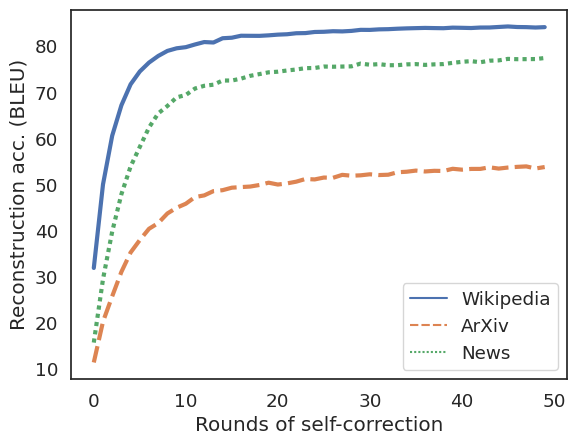

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.2, style="white")

new_df = df.melt(id_vars=['num_rounds'], value_vars=['nq_eval_bleu_score', 'arxiv_eval_bleu_score', 'xsum_doc_eval_bleu_score'])
new_df.to_parquet('multiround_sl32.parquet')
ax = sns.lineplot(data=new_df, x="num_rounds", y="value", hue="variable", style="variable", lw=3)

# Titles
# ax.set_title("Reconstruction performance improves across rounds")
ax.set_xlabel("Rounds of self-correction")
ax.set_ylabel("Reconstruction acc. (BLEU)")


# Change labels to something interpretable
L = plt.legend()
for i, label in enumerate(["Wikipedia", "ArXiv", "News"]):
    L.get_texts()[i].set_text(label)
    
# save to PDF
plt.savefig("multiround_sl32.pdf", format="pdf", bbox_inches="tight") 

In [41]:
all_metrics[-1]

{'nq_eval_loss': 0.6452354788780212,
 'nq_eval_token_set_precision': 0.9568612423044403,
 'nq_eval_token_set_recall': 0.9624170367965794,
 'nq_eval_token_set_f1': 0.9594496296846116,
 'nq_eval_bleu_score': 84.09693695426056,
 'nq_eval_meteor_score': 0.9413687286414782,
 'nq_eval_rouge_score': 0.9520987181354363,
 'nq_eval_bert_score': 0.9838602417707443,
 'nq_eval_exact_match': 0.52,
 'nq_eval_emb_cos_sim': 0.9906647205352783,
 'nq_eval_runtime': 113.2404,
 'nq_eval_samples_per_second': 4.415,
 'nq_eval_steps_per_second': 0.035,
 'arxiv_eval_loss': 1.7339987754821777,
 'arxiv_eval_token_set_precision': 0.8872689641541411,
 'arxiv_eval_token_set_recall': 0.8889101085918554,
 'arxiv_eval_token_set_f1': 0.8874387107985746,
 'arxiv_eval_bleu_score': 53.767067347226565,
 'arxiv_eval_meteor_score': 0.789265543874401,
 'arxiv_eval_rouge_score': 0.8722897604751119,
 'arxiv_eval_bert_score': 0.9468973543643951,
 'arxiv_eval_exact_match': 0.102,
 'arxiv_eval_emb_cos_sim': 0.9678734540939331,
 'a

<Axes: xlabel='num_rounds'>

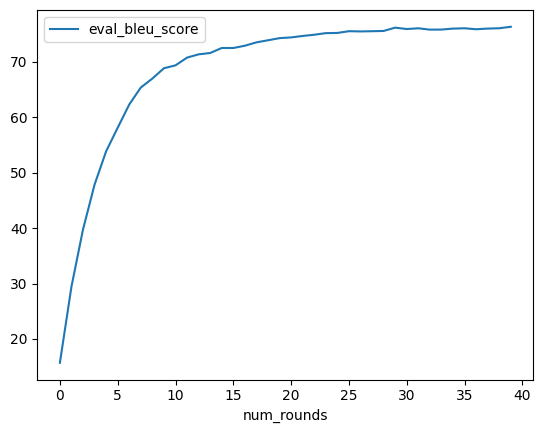

In [20]:
df.plot(x="num_rounds", y="eval_bleu_score")

<Axes: xlabel='num_rounds'>

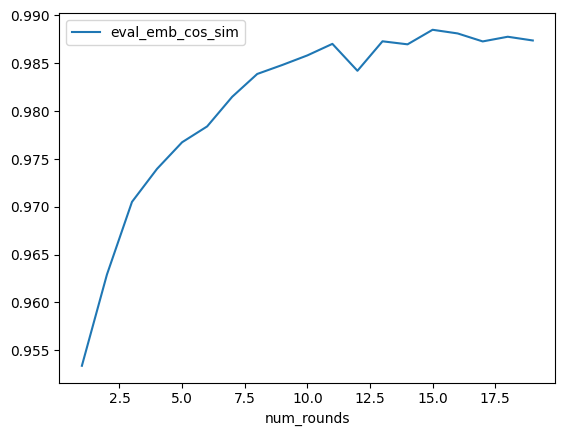

In [17]:
df.plot(x="num_rounds", y="eval_emb_cos_sim")

<Axes: xlabel='num_rounds'>

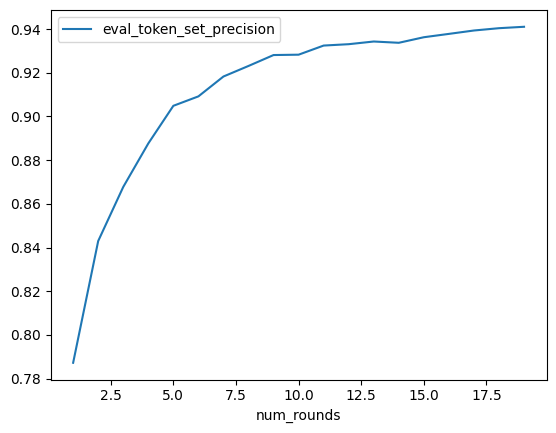

In [22]:
df.plot(x="num_rounds", y="eval_token_set_precision")

In [5]:
# trainer.evaluate(
#     trainer.preds_emb.shape

## plotting trajectories

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(trainer.preds_emb)

<Axes: >

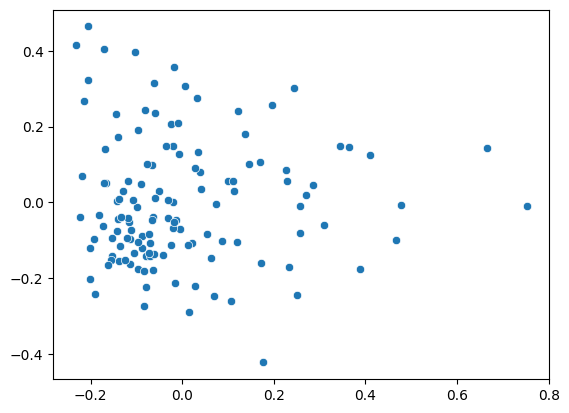

In [7]:
import seaborn as sns

x, y = pca.transform(trainer.preds_emb).T
sns.scatterplot(x=x, y=y)

In [147]:
trainer.embedder_tokenizer.decode(trainer.eval_dataset["nq"][335]["input_ids"])

'rowboat. The 2002 horror movie "The Ring" was in part filmed near the pass. The bridge is fictionalized as a toll bridge</s>'

In [122]:
trainer.gen_kwargs

{'early_stopping': False,
 'num_beams': 1,
 'do_sample': False,
 'no_repeat_ngram_size': 0}

In [124]:
from typing import Dict
import copy
import torch

def get_trajectories(inputs: Dict[str, torch.Tensor], num_beams: int = 1, num_rounds: int = 5) -> torch.Tensor:
    embeddings = []
    gen_kwargs = copy.copy(trainer.gen_kwargs)
    gen_kwargs["num_beams"] = num_beams
    frozen_embeddings = trainer.get_frozen_embeddings(
        embedder_input_ids=inputs["embedder_input_ids"],
        embedder_attention_mask=inputs["embedder_attention_mask"],
    )
    print("input:", trainer.embedder_tokenizer.decode(inputs["input_ids"][0]))
    for n in range(num_rounds):
        if n == 0:
            trainer.inversion_trainer.model.use_frozen_embeddings_as_input = False
            hypothesis = trainer.inversion_trainer.generate(inputs=inputs, generation_kwargs=gen_kwargs)
        else:
            hypothesis = trainer.generate(inputs=inputs, generation_kwargs=gen_kwargs, num_recursive_steps=1)
        # queue up next round             
        hypothesis_embedding = trainer.embed_generated_hypothesis(input_ids=hypothesis)
        inputs["frozen_embeddings"] = frozen_embeddings
        inputs["hypothesis_input_ids"] = hypothesis
        inputs["hypothesis_attention_mask"] = (hypothesis != trainer.model.encoder_decoder.config.pad_token_id).int()
        inputs["hypothesis_embedding"] = hypothesis_embedding
        # import pdb; pdb.set_trace()
        embeddings.append(hypothesis_embedding.cpu())
        dist = torch.nn.CosineSimilarity(dim=1)(hypothesis_embedding, frozen_embeddings).item()
        print(f"round {n+1} ({dist:.3f}):", trainer.embedder_tokenizer.decode(hypothesis[0]))
    return torch.stack(embeddings)

In [125]:
eval_batch = next(iter(trainer.get_eval_dataloader(eval_dataset=trainer.eval_dataset["arxiv"])))
eval_batch = {k: v[None, 4] for k,v in eval_batch.items() }
eval_batch = {k: v.to(trainer.args.device) for k,v in eval_batch.items() } # put on GPU
trainer.inversion_trainer.model.use_frozen_embeddings_as_input = False
# trainer.embedder_tokenizer.decode(().flatten())
trajectories = get_trajectories(inputs=eval_batch, num_rounds=8)

input: nowadays, scientific challenges usually require approaches that cross traditional boundaries between academic disciplines, driving many researchers towards interdisciplinarity. despite its obvious</s>
round 1 (0.908): <pad> in many disciplines challenges often involve a challenge that crosses traditional scientific boundaries rather than a challenge that follows interdisciplinarity. This has led to researchers
round 2 (0.953): <pad> nowadays, scientific challenges often require a cross between disciplines which approach interdisciplinarity and which naturally follows traditional academic boundaries. This may lead to researchers 
round 3 (0.961): <pad> nowadays, scientific challenges often require researchers to cross traditional academic boundaries and follow a different approach towards interdisciplinarity. This is obvious in many applications (
round 4 (0.973): <pad> nowadays, scientific challenges usually require approaches that cross traditional academic boundaries while dri

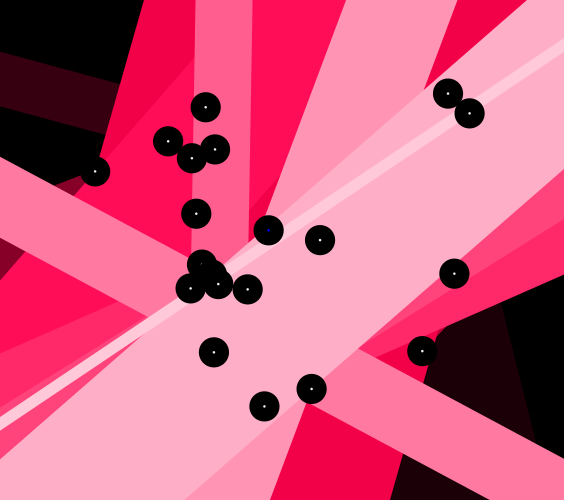

In [229]:
from colour import Color
from chalk import *

# https://chalk-diagrams.github.io/
set_svg_height(500) 

point_color = Color("black")
line_color = Color("#e0e0e0")

def grayscale(alpha: float) -> Color:
    assert 0 <= alpha <= 1.0
    return Color(hue=.95, saturation=1.0, luminance=alpha)

pca_trajec = PCA(n_components=2).fit(trajectories[:, 0, :])
# data = pca.transform(trajectories[:, 0, :]) * 5 # multiply to stretch things out
data = pca_trajec.transform(trajectories[:, 0, :])
# data = pd.DataFrame(data.T, columns=['x', 'y'])
# data['i'] = range(len(data))

line_points = []
for i in range(len(data)-1):
    x1, y1 = data[i]
    x2, y2 = data[i+1]
    if (x1 == x2) and (y1 == y2): continue
    line_points.append([(x1, y1), (x2, y2)])

frames = []

buffer = .1
minx = min([x for x,y in data]) - buffer
maxx = max([x for x,y in data]) + buffer
miny = min([y for x,y in data]) - buffer
maxy = max([y for x,y in data]) + buffer

pca_goal = pca_trajec.transform(eval_batch["frozen_embeddings"].cpu())
goal = circle(radius=.01).fill_color(Color("blue")).translate(*pca_goal.flatten())

for N in range(1, len(data)):
    background = rectangle(width=(maxx-minx), height=(maxy-miny)).fill_color(Color("white")).translate(minx+(maxx-minx)/2, maxy-(maxy-miny)/2)
    circles = concat(circle(radius=.01).fill_color(Color("#eee")).translate(x, y) for j, (x, y) in enumerate(data[:N]))
    lines = concat(make_path([p1, p2]).line_color(grayscale(i/len(line_points))).line_width(.8) for i, (p1, p2) in enumerate(line_points[:N-1]))
    frames.append(concat([background, lines, circles, goal]))

frames[-1]

/tmp/ipykernel_2427909/3542927145.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(path) for path in frame_paths]


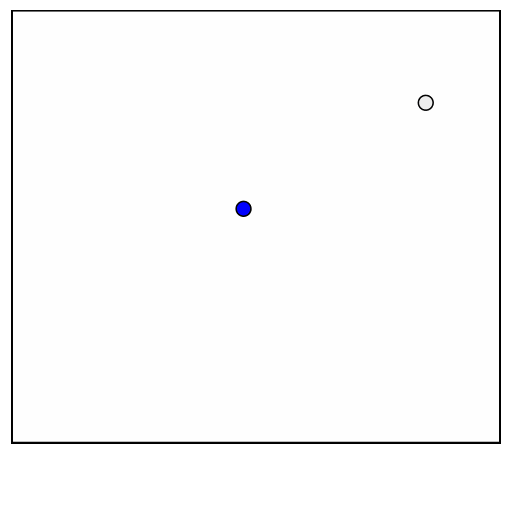

In [231]:
import imageio

hw = 512
frame_paths = []
for i, frame in enumerate(frames):
    path = f"frame_{i}.png"
    frame.render(path, height=hw, width=hw)
    frame_paths.append(path)

images = [imageio.imread(path) for path in frame_paths]
gif_path = "animation.gif"
imageio.mimsave(gif_path, images, duration=1)

# Display the GIF in the Jupyter Notebook
from IPython.display import Image, display
display(Image(filename=gif_path))

## Measuring closesness of hypotheses

Wondering how "comprehensive" our training data is – does it include "very close" hypotheses?

In [66]:
trainer.precompute_hypotheses()

Loading hypotheses from path /home/jxm3/research/retrieval/inversion/saves/db66b9c01b644541fedbdcc59c53a285/ebb31d91810c4b62d2b55b5382e8c7ea/526eed4aef8023828df2d1962356118f/410d3ac43b21b148_hypotheses.cache
Loading hypotheses from path /home/jxm3/research/retrieval/inversion/saves/db66b9c01b644541fedbdcc59c53a285/ebb31d91810c4b62d2b55b5382e8c7ea/526eed4aef8023828df2d1962356118f/faa7fd729fb13809_hypotheses.cache
Saving hypotheses to path /home/jxm3/research/retrieval/inversion/saves/db66b9c01b644541fedbdcc59c53a285/ebb31d91810c4b62d2b55b5382e8c7ea/526eed4aef8023828df2d1962356118f/f6cb440d7b1a11b3_hypotheses.cache


Precomputing hypotheses for data:   0%|          | 0/500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

Loading hypotheses from path /home/jxm3/research/retrieval/inversion/saves/db66b9c01b644541fedbdcc59c53a285/ebb31d91810c4b62d2b55b5382e8c7ea/526eed4aef8023828df2d1962356118f/c86e02d62c95721f_hypotheses.cache
Loading hypotheses from path /home/jxm3/research/retrieval/inversion/saves/db66b9c01b644541fedbdcc59c53a285/ebb31d91810c4b62d2b55b5382e8c7ea/526eed4aef8023828df2d1962356118f/0fc6efa35ccc8998_hypotheses.cache
Loading hypotheses from path /home/jxm3/research/retrieval/inversion/saves/db66b9c01b644541fedbdcc59c53a285/ebb31d91810c4b62d2b55b5382e8c7ea/526eed4aef8023828df2d1962356118f/69ab30859523c623_hypotheses.cache
Loading hypotheses from path /home/jxm3/research/retrieval/inversion/saves/db66b9c01b644541fedbdcc59c53a285/ebb31d91810c4b62d2b55b5382e8c7ea/526eed4aef8023828df2d1962356118f/bc62ad38b92d7dcb_hypotheses.cache


In [92]:
from typing import Dict
import torch

def add_distance_to_dataset(batch: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    e1 = torch.tensor(batch["frozen_embeddings"], device="cpu")#trainer.args.device)
    e2 = torch.tensor(batch["hypothesis_embedding"], device="cpu")#trainer.args.device)
    batch["hypothesis_distance"] = torch.nn.CosineSimilarity(dim=1)(e1, e2).cpu()
    return batch

ds_with_distances = trainer.train_dataset.select(range(10**6)).map(add_distance_to_dataset, batched=True, batch_size=8192)

Map:   0%|          | 0/1000000 [00:00<?, ? examples/s]

In [ ]:
# https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot
ax = sns.histplot(ds_with_distances["hypothesis_distance"], bins=150)

ax.set_xlim([.7,1])
ax.set_ylim([0, 30_000])
ax.set_xlabel("Cosine distance from hypothesis to true embedding")
# ax.set_xscale("log")

# save to PDF
plt.savefig("train_hypothesis_distance_sl32.pdf", format="pdf", bbox_inches="tight") 

## looking for failure cases in arxiv data

In [ ]:
trainer.gen_kwargs = {
    "early_stopping": False,
    "num_beams": 1,
    "do_sample": False,
    "no_repeat_ngram_size": 0,
}
trainer.num_gen_recursive_steps = 20
trainer.inversion_trainer.model.use_frozen_embeddings_as_input = True
metrics = trainer.evaluate(
    eval_dataset=eval_dataset,
    metric_key_prefix=f"eval_arxiv",
)
print(metrics)

In [119]:
# worst arxiv reconstructions by bertscore:
# [424, 201, 471,  86, 254, 237,  49, 321,  36, 284, 433, 107, 316, ...]
eval_batch = next(iter(trainer.get_eval_dataloader(eval_dataset=trainer.eval_dataset["arxiv"])))
eval_batch = {k: v[None, 49] for k,v in eval_batch.items() }
eval_batch = {k: v.to(trainer.args.device) for k,v in eval_batch.items() } # put on GPU
trainer.inversion_trainer.model.use_frozen_embeddings_as_input = False
# trainer.embedder_tokenizer.decode(().flatten())
trajectories = get_trajectories(inputs=eval_batch, num_rounds=8)

input: in this paper, we use belief - propagation techniques to develop fast algorithms for image inpainting. unlike traditional gradient - </s>
round 1 (0.850): <pad> believe propagation techniques.... In this paper we use gradients to develop a more fast and effective image-based belief
round 2 (0.903): <pad> than traditional belief techniques. In this paper we use propagation algorithms to develop fast, in-depth, gradient-painting. ii
round 3 (0.940): <pad> as in this paper.. we use belief techniques to develop propagation algorithms - fast in traditional gradient and image-painting.
round 4 (0.884): <pad> than in traditional belief techniques.. we develop propagation techniques for fast image-painting. In this paper we use gradient.
round 5 (0.921): <pad> than in traditional belief algorithms... We use propagation techniques to develop fast or gradient in image-painting. This paper is
round 6 (0.860): <pad> than in traditional paper., we use propagation techniques to develop fast g

In [134]:
# worst arxiv reconstructions by bertscore:
# [424, 201, 471,  86, 254, 237,  49, 321,  36, 284, 433, 107, 316, ...]
eval_batch = next(iter(trainer.get_eval_dataloader(eval_dataset=trainer.eval_dataset["arxiv"])))
eval_batch = {k: v[None, 49] for k,v in eval_batch.items() }
eval_batch = {k: v.to(trainer.args.device) for k,v in eval_batch.items() } # put on GPU
trainer.inversion_trainer.model.use_frozen_embeddings_as_input = False
# trainer.embedder_tokenizer.decode(().flatten())

print("** num_beams=1 **")
trajectories = get_trajectories(inputs=eval_batch, num_beams=1, num_rounds=16)

print("** num_beams=32 **")
trajectories = get_trajectories(inputs=eval_batch, num_beams=8, num_rounds=16)

** num_beams=1 **
input: in this paper, we use belief - propagation techniques to develop fast algorithms for image inpainting. unlike traditional gradient - </s>
round 1 (0.850): <pad> believe propagation techniques.... In this paper we use gradients to develop a more fast and effective image-based belief
round 2 (0.903): <pad> than traditional belief techniques. In this paper we use propagation algorithms to develop fast, in-depth, gradient-painting. ii
round 3 (0.940): <pad> as in this paper.. we use belief techniques to develop propagation algorithms - fast in traditional gradient and image-painting.
round 4 (0.884): <pad> than in traditional belief techniques.. we develop propagation techniques for fast image-painting. In this paper we use gradient.
round 5 (0.921): <pad> than in traditional belief algorithms... We use propagation techniques to develop fast or gradient in image-painting. This paper is
round 6 (0.860): <pad> than in traditional paper., we use propagation techniques

In [295]:
def bleu(s1: str, s2: str) -> float:
    m = trainer.metric_bleu.compute(
        predictions=[s1], references=[s2],
    )
    print(m)
    return m["score"]

bleu(
    "in this paper, we use belief - propagation techniques to develop fast algorithms for image inpainting. unlike traditional gradient - ",
    "as in belief propagation. In this paper, we use fast techniques to develop gradient and image-painting algorithms.. Unlike traditional",
)

{'score': 24.57498456289153, 'counts': [16, 6, 4, 2], 'totals': [22, 21, 20, 19], 'precisions': [72.72727272727273, 28.571428571428573, 20.0, 10.526315789473685], 'bp': 0.9555630362682843, 'sys_len': 22, 'ref_len': 23}


24.57498456289153

## test words in training

In [187]:
from typing import Dict
from collections import Counter
import torch


vocab_size = trainer.embedder_tokenizer.vocab_size
word_counts = Counter()

def count_words_freq(batch: Dict[str, torch.Tensor]) -> None:
    global word_counts
    str_list = trainer.embedder_tokenizer.batch_decode(batch["embedder_input_ids"], skip_special_tokens=True)
    s = "\n".join(str_list)
    word_counts.update(s.split())
    

trainer.train_dataset.map(count_words_freq, batched=True, batch_size=1024)

import pickle
pickle.dump(word_counts, open("nq_train_word_counts.p", "wb"))
# pickle.dump(token_counts, open("nq_train_token_counts.p", "wb"))

Map:   0%|          | 0/5332023 [00:00<?, ? examples/s]

In [ ]:
from data_helpers import load_standard_val_datasets
from tokenize_data import tokenize_function
import transformers

def load_arxiv(max_eval_samples: int):
    max_eval_samples
    val_datasets_dict = load_standard_val_datasets()
    tokenizer = transformers.AutoTokenizer.from_pretrained(
        "t5-base",
        padding=True,
        truncation="max_length",
        max_length=32,
    )

    val_datasets_dict = val_datasets_dict.map(
        tokenize_function(
            tokenizer,
            trainer.embedder_tokenizer,
            "text",
            32,
        ),
        remove_columns=["text"],
        batched=True,
        desc="Running tokenizer on dataset",
    )

    for name, dataset in val_datasets_dict.items():
        max_eval_samples = min(len(dataset), max_eval_samples)
        val_datasets_dict[name] = val_datasets_dict[name].select(
            range(max_eval_samples)
        )
        val_datasets_dict[name] = val_datasets_dict[name].add_column(
            "idx", range(len(val_datasets_dict[name]))
        )
    
    return val_datasets_dict["arxiv"]

arxiv = load_arxiv(10_000)

In [355]:
trainer.eval_dataset.keys()

dict_keys(['ag_news', 'arxiv', 'xsum_doc', 'xsum_summ', 'wikibio', 'nq'])

In [356]:
trainer.num_gen_recursive_steps = 10
trainer.inversion_trainer.model.use_frozen_embeddings_as_input = True
metrics = trainer.evaluate(
    eval_dataset=trainer.eval_dataset["nq"],
    metric_key_prefix=f"eval_nq",
)
metrics

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H


{'eval_nq_loss': 0.6452354788780212,
 'eval_nq_token_set_precision': 0.9378606822414812,
 'eval_nq_token_set_recall': 0.9442479841148055,
 'eval_nq_token_set_f1': 0.9408037307960407,
 'eval_nq_bleu_score': 79.75680103758263,
 'eval_nq_meteor_score': 0.9165888519814936,
 'eval_nq_rouge_score': 0.9312237417103695,
 'eval_nq_bert_score': 0.9786610765457153,
 'eval_nq_exact_match': 0.476,
 'eval_nq_emb_cos_sim': 0.9863787293434143,
 'eval_nq_runtime': 25.3197,
 'eval_nq_samples_per_second': 19.747,
 'eval_nq_steps_per_second': 0.158}

In [357]:
preds_sample = trainer.embedder_tokenizer.batch_decode(trainer.preds_sample_list, skip_special_tokens=True)
preds_sample_words = list(map(str.split, preds_sample))
preds_sample_labels = trainer.embedder_tokenizer.batch_decode(trainer.preds_sample_labels_list, skip_special_tokens=True)
preds_sample_labels_words = list(map(str.split, preds_sample_labels))

In [358]:
len(trainer.preds_sample_list)

500

In [359]:
word_counts_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

In [360]:
word_counts_df.tail()

,word,count
3175480,“avar”,1
3175481,“conqueror”),1
3175482,"Yesterdays,",1
3175483,Desta's,1
3175484,"Aeronautica"").",1


In [371]:
word_counts_trimmed = {k:v for k,v in word_counts.items() if v>(10**2) }

In [372]:
len(word_counts_trimmed), len(word_counts)

(54473, 3175485)

In [378]:
sns.reset_orig()

plt.hist(word_counts_trimmed.keys(), weights=word_counts_trimmed.values(), bins=range(50), histtype='step')
plt.show()

KeyboardInterrupt: 

In [366]:
correct_words = []
incorrect_words = []

for pred_words, true_words in zip(preds_sample_words, preds_sample_labels_words):
    for w in true_words:
        word_in_training_data = (word_counts[w] > 0)
        if not word_in_training_data:
            print(w)
        word_correct = (w in pred_words)
        if word_correct:
            correct_words.append(w)
        else:
            # if word_counts[w] > 5*10**6:
            #     print(w)
            #     print(" ".join(pred_words))
            #     print(" ".join(true_words))
            #     print()
            incorrect_words.append(w)


data = []
for w in set(correct_words):
    data.append((w, True, word_counts[w]))
for w in set(incorrect_words):
    data.append((w, False, word_counts[w]))
word_df = pd.DataFrame(data, columns=['word', 'guess_correct', 'count'])
word_df["count"] += 1
word_df.head()

untortuous.
Minworth
(Kathi
Hagerstown's
"linga".
Celone/San
d'Arpi
Celone/San
Prozac"
Ebingen,
$2–2.5
(Transnistrian
Nonmagnetic
induction-welded
"...it’
YYO
Wymott
3442
Barentsz,
Steptoeville,
Abernetty
Abernetty
Steinbeck-Ancker
Chateaud
TGFBI
beta-induced,
68kDa,
TGFBI
Doaks
Finger'
acumin
Schultzy's.
hazel/alder
'Happiness
Tents'
Katarina"
Rößl"
[Western
Pentapartito
Pentapartito
"Penta",
"partito",
"Türmle",
""Selshamurinn
Biogenesis.
11,1%
(1812–1823)
Riesenberger
paresthesia.
hypog
19J
Rudorfer
(Intro
Off")")
Ichihara.
"Tsubas
Warblington
79–82
caldeira
Black-bearded
melanopogon")
19/23
Monofats
Varifold
varifold
attacks/infiltrations.
style="background:#990033;
prison—and
Scharlach
"Judeo-Bolshevism"
Zempter
value-addition
CpE
"Tianzi",
Passera,
"Abbas
Cyrus".
("Peak"),
Akaln.
nowiki>"/nowiki>.
Isralietisch
Israelietisch
Kanights
Kanights
Daprosy
"timbuwarra"
Dadov"
("Duh
slowcore/post-rock
fastned
(play-offs)
GTS:
Mandy-González
"ee"
microbodies
Creditors'
184513
al-Ashram,
K

,word,guess_correct,count
0,Kerim,True,18
1,visit,True,5925
2,holdings,True,537
3,creolized,True,7
4,Apart,True,1321


In [363]:
word_df[word_df["count"] > 10**6]["word"].unique()

array(['to', 'the', 'of', 'and', 'a', 'was', 'is', 'in', 'The'],
      dtype=object)

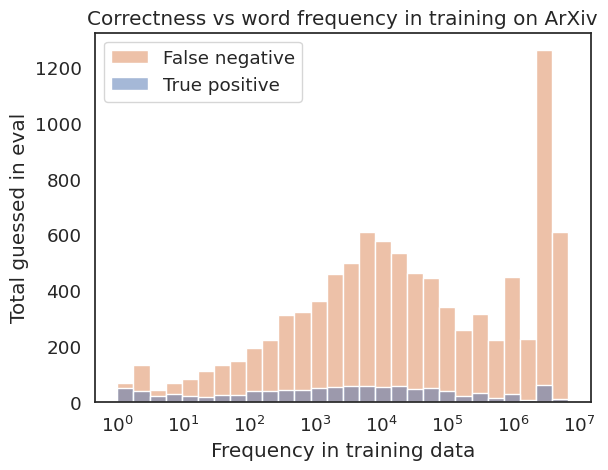

In [364]:
import math
import seaborn as sns

ax = sns.histplot(data=word_df, x="count", hue="guess_correct", label="guess_correct", log_scale=True, legend=True)

ax.set_ylabel("Total guessed in eval")
ax.set_xlabel("Frequency in training data")
ax.set_title("Correctness vs word frequency in training on ArXiv")

# Change labels to something interpretable
L = plt.legend()
for i, label in enumerate(["False negative", "True positive"]):
    L.get_texts()[i].set_text(label)
    
# save to PDF
plt.savefig("incorrect_word_dist_sl32.pdf", format="pdf", bbox_inches="tight") 